In [43]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from scipy.ndimage import sobel

In [45]:
data_dir = 'Banana Leaf Disease Detection dataset'
# Image Augmentation and Data Preparation
datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    rotation_range=40,  # Random rotations
    width_shift_range=0.2,  # Horizontal shifts
    height_shift_range=0.2,  # Vertical shifts
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Horizontal flip
    fill_mode='nearest'  # Fill in missing pixels
)

train_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='validation')

Found 2615 images belonging to 7 classes.
Found 650 images belonging to 7 classes.


In [46]:
# Compute Class Weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights)

{0: 0.8707958707958708, 1: 1.1674107142857142, 2: 0.6779880736323568, 3: 0.6779880736323568, 4: 1.0582760016187778, 5: 1.4204236827810972, 6: 2.5241312741312742}


In [47]:
class_weights

{0: 0.8707958707958708,
 1: 1.1674107142857142,
 2: 0.6779880736323568,
 3: 0.6779880736323568,
 4: 1.0582760016187778,
 5: 1.4204236827810972,
 6: 2.5241312741312742}

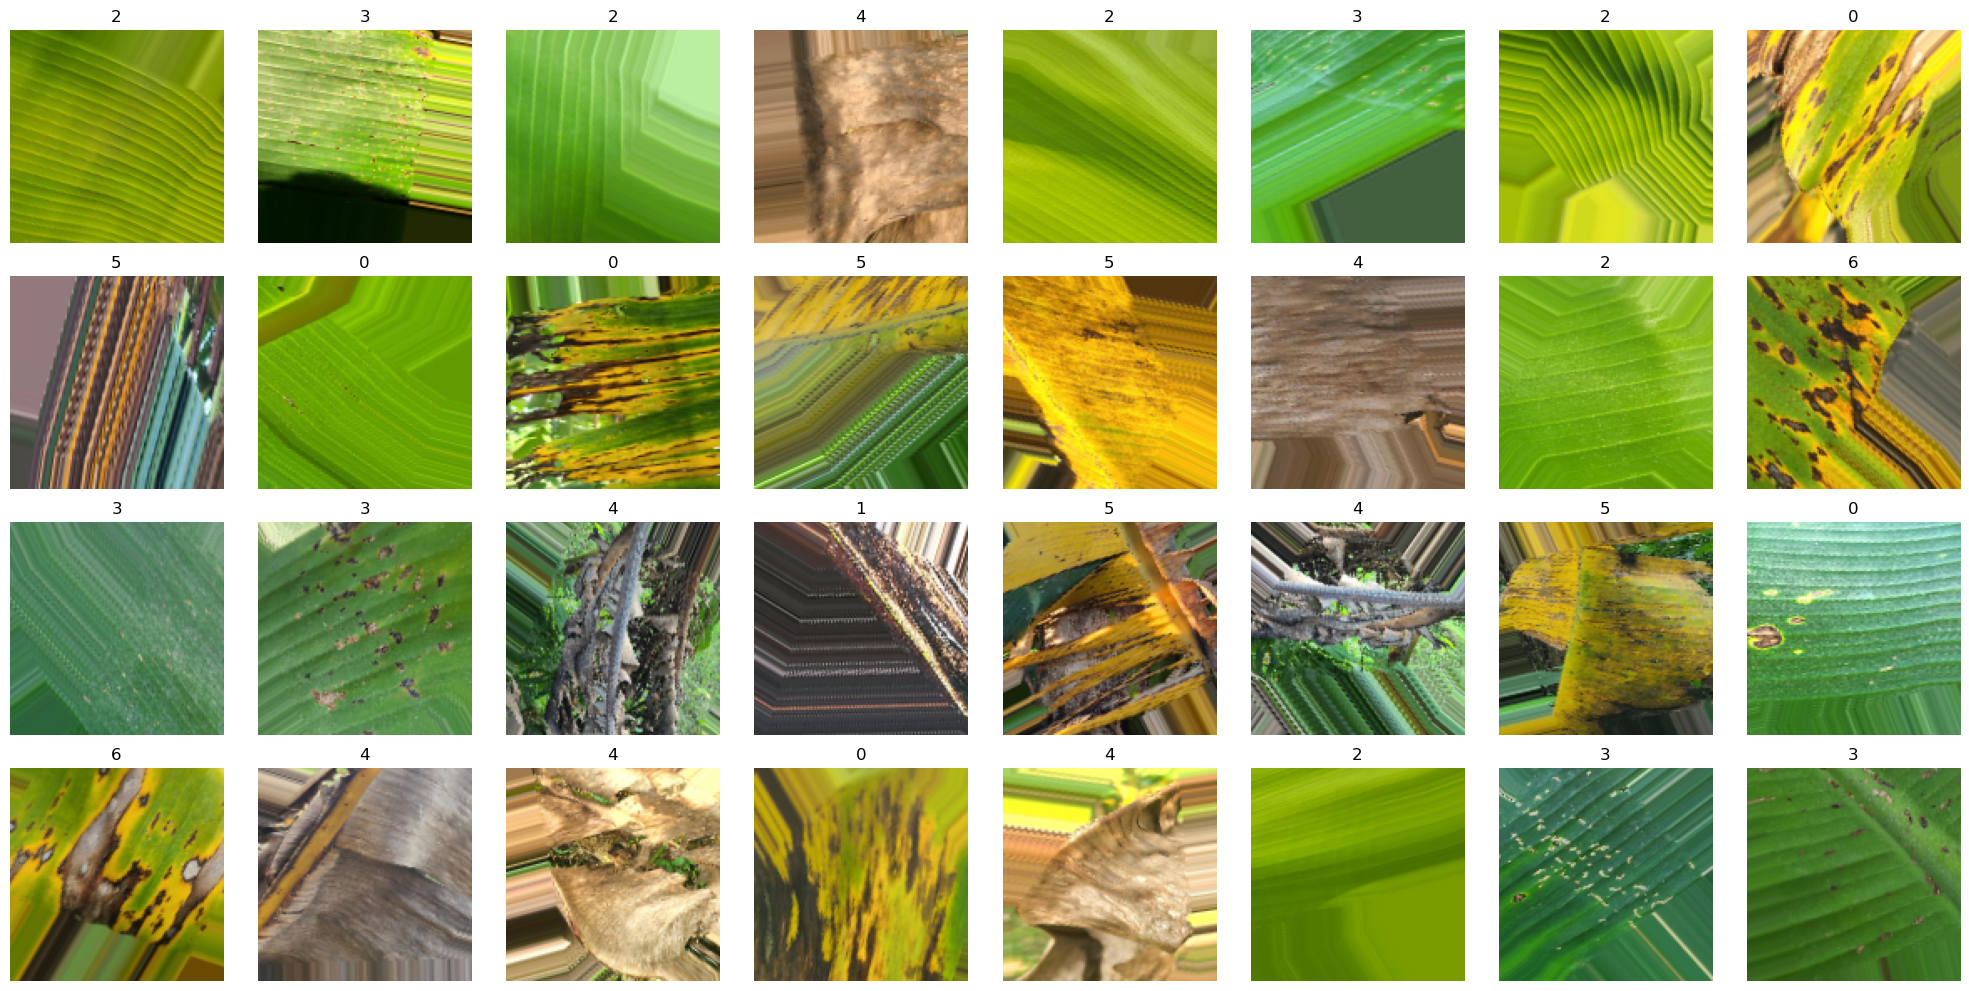

In [48]:
images, labels = next(train_generator)

def plot_images(images_arr, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(np.argmax(lbl))
    plt.tight_layout()
    plt.show()

plot_images(images, labels)

In [49]:
def apply_sobel(images_arr):
    sobel_images = []
    for img in images_arr:
        gray_img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
        sobel_x = sobel(gray_img, axis=0, mode='constant')
        sobel_y = sobel(gray_img, axis=1, mode='constant')
        sobel_img = np.hypot(sobel_x, sobel_y)
        sobel_images.append(sobel_img)
    return np.array(sobel_images)

sobel_images = apply_sobel(images)

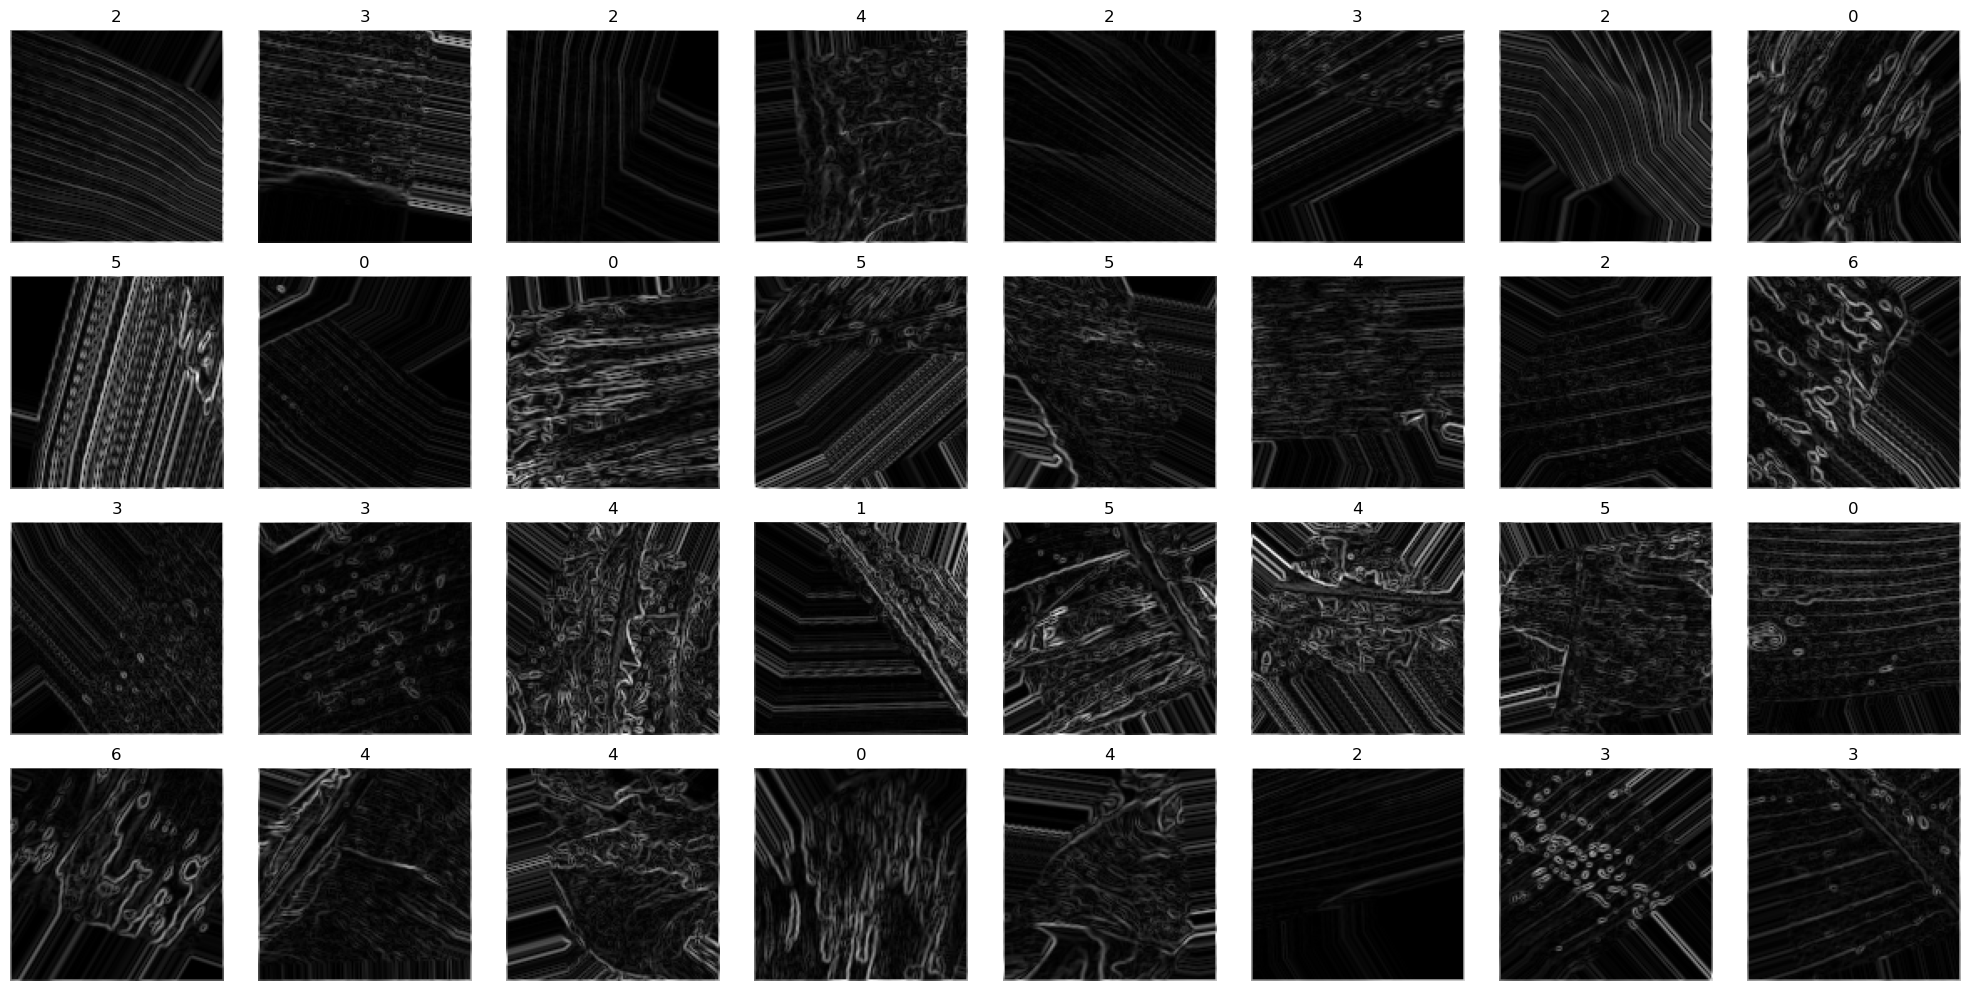

In [50]:
def plot_sobel_images(original_images, sobel_images, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for orig_img, sob_img, lbl, ax in zip(original_images, sobel_images, labels_arr, axes):
        ax.imshow(sob_img, cmap='gray')
        ax.axis('off')
        ax.set_title(np.argmax(lbl))
    plt.tight_layout()
    plt.show()

plot_sobel_images(images, sobel_images, labels)

In [51]:
type(train_generator)

keras.src.legacy.preprocessing.image.DirectoryIterator

In [60]:
model_lenet = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    GlobalAveragePooling2D(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(7, activation='softmax')
])

In [61]:
model_lenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_lenet.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 124, 124, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 60, 60, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 58, 58, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 27, 27, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 27, 27, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 25, 25, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │              

 Total params: 1,275,303 (4.86 MB)

 Trainable params: 1,273,575 (4.86 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [62]:
history_lenet = model_lenet.fit(train_generator, epochs=10, validation_data=val_generator, class_weight=class_weights)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 744s 7s/step - accuracy: 0.2727 - loss: 2.3843 - precision_2: 0.3102 - recall_2: 0.1791 - val_accuracy: 0.2108 - val_loss: 3.4338 - val_precision_2: 0.2495 - val_recall_2: 0.2108
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 518s 6s/step - accuracy: 0.4077 - loss: 1.6518 - precision_2: 0.4752 - recall_2: 0.3066 - val_accuracy: 0.2969 - val_loss: 2.1631 - val_precision_2: 0.4414 - val_recall_2: 0.2262
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 419s 5s/step - accuracy: 0.4208 - loss: 1.5137 - precision_2: 0.4843 - recall_2: 0.3147 - val_accuracy: 0.2554 - val_loss: 2.2978 - val_precision_2: 0.2000 - val_recall_2: 0.1015
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 549s 6s/step - accuracy: 0.4651 - loss: 1.3946 - precision_2: 0.5181 - recall_2: 0.3511 - val_accuracy: 0.2692 - val_loss: 1.8657 - val_precision_2: 0.4172 - val_recall_2: 0.2092
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 621s 7s/step - accuracy: 0.4903 - loss: 1.3007 - precision_2: 0.5593 - recall_2: 0.3740 - val_

In [63]:
## Result

In [64]:
def plot_performance(history, title):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{title} Loss')
    plt.legend()

    plt.show()

In [65]:
def evaluate_model(model, generator):
    y_true = generator.classes
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)
    cr = classification_report(y_true, y_pred_classes, target_names=generator.class_indices.keys())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=generator.class_indices.keys(), yticklabels=generator.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print('Classification Report:')
    print(cr)

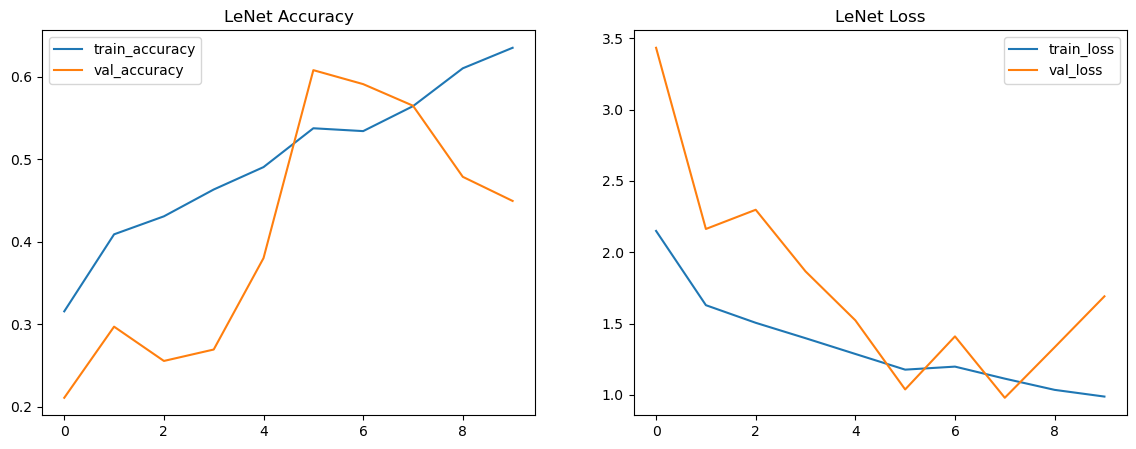

In [66]:
plot_performance(history_lenet, 'LeNet')

21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step


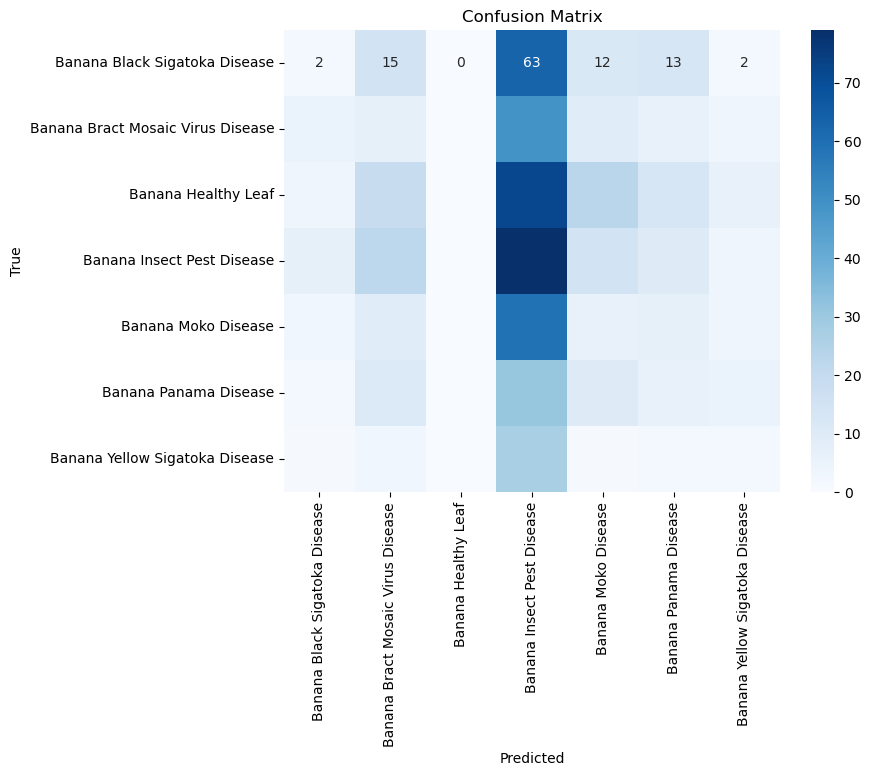

Classification Report:
                                   precision    recall  f1-score   support

    Banana Black Sigatoka Disease       0.08      0.02      0.03       107
Banana Bract Mosaic Virus Disease       0.08      0.09      0.08        80
              Banana Healthy Leaf       0.00      0.00      0.00       137
       Banana Insect Pest Disease       0.21      0.58      0.31       137
              Banana Moko Disease       0.08      0.07      0.07        88
            Banana Panama Disease       0.11      0.09      0.10        65
   Banana Yellow Sigatoka Disease       0.07      0.06      0.06        36

                         accuracy                           0.16       650
                        macro avg       0.09      0.13      0.09       650
                     weighted avg       0.09      0.16      0.10       650



In [67]:
evaluate_model(model_lenet, val_generator)

In [69]:
model_lenet.save('model_lenet_Demo.keras')